In [94]:
import psycopg2
import pandas as pd
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import log_loss

In [2]:
params = params = {
    "host": "localhost",
    "user": "postgres",
    "port": 5432
}
connection = psycopg2.connect(**params, dbname= "postgres")

In [3]:
df = pd.read_sql("select * from public.spotify_log sl join public.spotify_track st on sl.track_id_clean = st.track_id;", connection)

/Users/hasanenesguray/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,4,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,10,20,t_2af4dfa0-7df3-4b7e-b7ab-353ba48237f9,True,True,True,False,0,1,...,4,0.257672,-0.647221,0.316101,0.251329,-0.041532,-0.252359,0.059971,-0.313696,0.126421
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,11,20,t_79570b2a-639a-4ec0-9853-71c5299ac44d,True,True,True,False,0,1,...,4,0.037998,-0.573548,0.284808,0.249904,-0.080877,-0.337629,0.116421,-0.337717,0.247187
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,17,20,t_bff5b6c6-6968-41be-b723-7e860b372975,False,True,True,False,0,1,...,4,0.283693,-0.837439,0.368295,0.271468,0.024429,-0.292806,0.032801,-0.485078,0.183784
4,0_0000a72b-09ac-412f-b452-9b9e79bded8f,2,20,t_0632570b-b4b4-4c3c-b47c-443ec9fbaa11,True,True,True,False,0,1,...,4,0.555482,0.203349,0.247835,-0.136071,-0.440866,0.680082,0.181352,-0.279335,0.001125


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 51 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  int64  
 2   session_length                   167880 non-null  int64  
 3   track_id_clean                   167880 non-null  object 
 4   skip_1                           167880 non-null  bool   
 5   skip_2                           167880 non-null  bool   
 6   skip_3                           167880 non-null  bool   
 7   not_skipped                      167880 non-null  bool   
 8   context_switch                   167880 non-null  int64  
 9   no_pause_before_play             167880 non-null  int64  
 10  short_pause_before_play          167880 non-null  int64  
 11  long_pause_before_play           167880 non-null  int64  
 12  hi

In [6]:
df.date.unique()

array(['2018-07-15', '2018-07-14', '2018-07-13', '2018-07-12',
       '2018-06-05', '2018-07-11', '2018-07-16', '2018-07-10',
       '2018-07-04', '2018-07-05', '2018-07-07', '2018-07-06',
       '2018-05-12', '2018-07-09', '2018-06-29', '2018-06-30',
       '2018-06-19', '2018-05-18'], dtype=object)

In [7]:
def weekday_converter(date):
    format = '%Y-%m-%d'
    datetime_date = datetime.datetime.strptime(date,format)
    weekdays_list = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    return weekdays_list[datetime_date.weekday()]

df = df.assign(weekday=df.date.apply(weekday_converter))
df.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,weekday
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604,Sunday
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,10,20,t_2af4dfa0-7df3-4b7e-b7ab-353ba48237f9,True,True,True,False,0,1,...,0.257672,-0.647221,0.316101,0.251329,-0.041532,-0.252359,0.059971,-0.313696,0.126421,Sunday
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,11,20,t_79570b2a-639a-4ec0-9853-71c5299ac44d,True,True,True,False,0,1,...,0.037998,-0.573548,0.284808,0.249904,-0.080877,-0.337629,0.116421,-0.337717,0.247187,Sunday
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,17,20,t_bff5b6c6-6968-41be-b723-7e860b372975,False,True,True,False,0,1,...,0.283693,-0.837439,0.368295,0.271468,0.024429,-0.292806,0.032801,-0.485078,0.183784,Sunday
4,0_0000a72b-09ac-412f-b452-9b9e79bded8f,2,20,t_0632570b-b4b4-4c3c-b47c-443ec9fbaa11,True,True,True,False,0,1,...,0.555482,0.203349,0.247835,-0.136071,-0.440866,0.680082,0.181352,-0.279335,0.001125,Sunday


In [8]:
def track_age_calculator(year):
    return 2022-year

df = df.assign(track_age=df.release_year.apply(track_age_calculator))
df[['release_year','track_age']]

,release_year,track_age
0,2018,4
1,2018,4
2,2018,4
3,2018,4
4,1974,48
...,...,...
167875,2015,7
167876,2018,4
167877,2018,4
167878,2018,4


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 53 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  int64  
 2   session_length                   167880 non-null  int64  
 3   track_id_clean                   167880 non-null  object 
 4   skip_1                           167880 non-null  bool   
 5   skip_2                           167880 non-null  bool   
 6   skip_3                           167880 non-null  bool   
 7   not_skipped                      167880 non-null  bool   
 8   context_switch                   167880 non-null  int64  
 9   no_pause_before_play             167880 non-null  int64  
 10  short_pause_before_play          167880 non-null  int64  
 11  long_pause_before_play           167880 non-null  int64  
 12  hi

In [10]:
df.drop('session_id', inplace=True, axis=1)
df.drop('track_id_clean', inplace=True, axis=1)
df.drop('skip_1', inplace=True, axis=1)
df.drop('skip_3', inplace=True, axis=1)
df.drop('not_skipped', inplace=True, axis=1)
df.drop('date', inplace=True, axis=1)
df.drop('track_id', inplace=True, axis=1)

In [12]:
df = pd.get_dummies(df, columns=['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
                                      'weekday','mode'], drop_first=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   session_position                            167880 non-null  int64  
 1   session_length                              167880 non-null  int64  
 2   skip_2                                      167880 non-null  bool   
 3   context_switch                              167880 non-null  int64  
 4   no_pause_before_play                        167880 non-null  int64  
 5   short_pause_before_play                     167880 non-null  int64  
 6   long_pause_before_play                      167880 non-null  int64  
 7   hist_user_behavior_n_seekfwd                167880 non-null  int64  
 8   hist_user_behavior_n_seekback               167880 non-null  int64  
 9   hist_user_behavior_is_shuffle               167880 non-null  bool   
 

In [14]:
df["skip_2"] = df["skip_2"].astype(int)
df["hist_user_behavior_is_shuffle"] = df["hist_user_behavior_is_shuffle"].astype(int)
df["premium"] = df["premium"].astype(int)

In [15]:
target_count = df.skip_2.value_counts(normalize=True)
target_count

1    0.517179
0    0.482821
Name: skip_2, dtype: float64

In [16]:
columns = df.columns.tolist()
columns = [columns[2]] + columns[0:2] + columns[3:]
df = df[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   skip_2                                      167880 non-null  int64  
 1   session_position                            167880 non-null  int64  
 2   session_length                              167880 non-null  int64  
 3   context_switch                              167880 non-null  int64  
 4   no_pause_before_play                        167880 non-null  int64  
 5   short_pause_before_play                     167880 non-null  int64  
 6   long_pause_before_play                      167880 non-null  int64  
 7   hist_user_behavior_n_seekfwd                167880 non-null  int64  
 8   hist_user_behavior_n_seekback               167880 non-null  int64  
 9   hist_user_behavior_is_shuffle               167880 non-null  int64  
 

In [57]:
scale = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], 
                                                    test_size = 0.25, random_state=42)

X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_transformed, y_train)
print('LogReg Test Score: {:6.2f}%'.format(100*logreg.score(X_test_transformed, y_test)))

LogReg Test Score:  87.33%


In [58]:
def make_confusion_matrix(model, threshold=0.5): # Default threshold value
    y_predict = (model.predict_proba(X_test_transformed)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=120)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['not skipped', 'skipped'],
           yticklabels=['not skipped', 'skipped']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

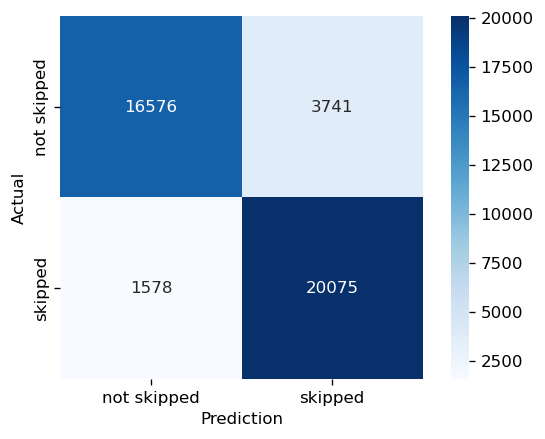

In [59]:
make_confusion_matrix(logreg)

In [60]:
# A widget to interactively change the result when we change the threshold value

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(logreg, threshold), threshold=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

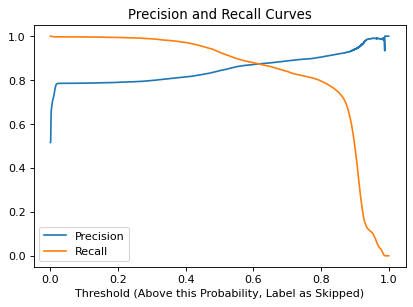

In [77]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg.predict_proba(X_test_transformed)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='Precision')
plt.plot(threshold_curve, recall_curve[1:], label='Recall')
plt.legend()
plt.xlabel('Threshold (Above this Probability, Label as Skipped)');
plt.title('Precision and Recall Curves');

In [74]:
y_predict = logreg.predict(X_test_transformed)
print('Default Threshold: 0.5')
print('Precision: {:6.3f},   Recall: {:6.3f},   F1 Score: {:6.3f}' .format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict),
                                                    f1_score(y_test, y_predict)))

Default Threshold: 0.5
Precision:  0.843,   Recall:  0.927,   F1 Score:  0.883


In [75]:
# Classification based on threshold value of 0.4 to get the max F1 Score!
new_threshold = 0.4
y_predict_th = (logreg.predict_proba(X_test_transformed)[:,1] > new_threshold)
print('New Threshold:', new_threshold)
print('Precision: {:6.3f},   Recall: {:6.3f},   F1 Score: {:6.3f}'.format(precision_score(y_test, y_predict_th), 
                                                     recall_score(y_test, y_predict_th),
                                                    f1_score(y_test, y_predict_th)))

New Threshold: 0.4
Precision:  0.815,   Recall:  0.971,   F1 Score:  0.886


In [71]:
# Classification by threshold value of 0.6, Recall value is so close to the Precision value.
new_threshold = 0.6
y_predict_th = (logreg.predict_proba(X_test_transformed)[:,1] > new_threshold)
print('New Threshold:', new_threshold)
print('Precision: {:6.3f},   Recall: {:6.3f},   F1 Score: {:6.3f}'.format(precision_score(y_test, y_predict_th), 
                                                     recall_score(y_test, y_predict_th),
                                                    f1_score(y_test, y_predict_th)))

New Threshold: 0.6
Precision:  0.871,   Recall:  0.879,   F1 Score:  0.875


In [86]:
def new_make_confusion_matrix(model, threshold=0.4):
    y_predict = (model.predict_proba(X_test_transformed)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=120)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['not skipped', 'skipped'],
           yticklabels=['not skipped', 'skipped']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

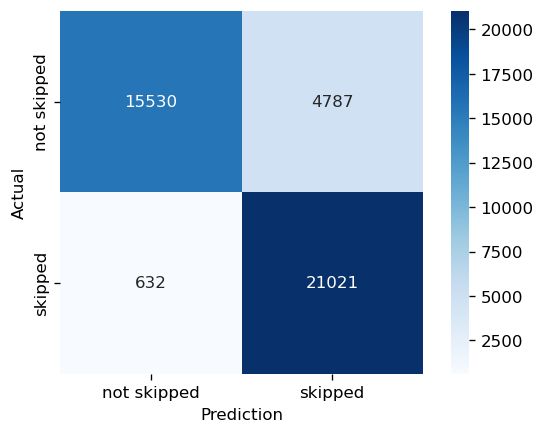

In [87]:
new_make_confusion_matrix(logreg)

AUC Score= 0.943


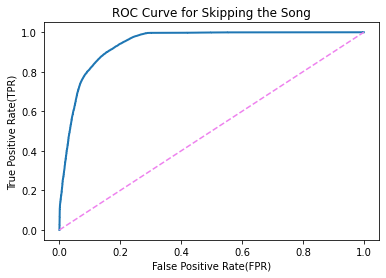

In [97]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_transformed)[:,1])

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve for Skipping the Song');
print("AUC Score=", round(roc_auc_score(y_test, logreg.predict_proba(X_test_transformed)[:,1]),3))

In [96]:
print("Log-Loss: {:2.3f}".format(log_loss(y_test, logreg.predict_proba(X_test_transformed))))

Log-Loss: 0.281
